In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from evaluate_model import component_matching_f1

In [10]:
MODELS = {
    "Qwen/Qwen2.5-Coder-7B": "qwen25_coder_7b",
    "mistralai/Mistral-7B-Instruct-v0.3": "mistral_7b",
    "Qwen/Qwen2.5-Coder-1.5B-Instruct": "qwen25_coder_inst_1_5b",
    "Qwen/Qwen2.5-1.5B-Instruct": "qwen25_inst_8k_1_5b",
    "Qwen/Qwen3-1.7B": "qwen3_1.7b",
    "Qwen/Qwen2.5-7B-Instruct": "qwen25_inst_7b",
    "t-tech/T-lite-it-1.0": "tlite",
    "Qwen/Qwen2.5-Coder-14B-Instruct": "qwen25_coder_inst_14b",
    "microsoft/phi-4": "phi4",
}

In [11]:
def compute_metrics(df: pd.DataFrame) -> dict:
    """
    Вычисляет точечные оценки метрик на DataFrame df.
    Возвращает словарь с execution_accuracy, exact_match и F1 для каждого компонента.
    """
    metrics = {}
    # Доля успешно выполненных запросов
    metrics['execution_accuracy'] = df['executed'].mean()
    # Доля точных совпадений запросов
    metrics['exact_match'] = df['exact'].mean()
    # F1-метрики по компонентам
    component_cols = ['select', 'from', 'where', 'group by', 'having', 'order by']
    for col in component_cols:
        key = f'f1_{col.replace(" ", "_")}'
        metrics[key] = df[col].mean()
    return metrics

def bootstrap_metrics(
    df: pd.DataFrame,
    metric_func,
    n_bootstrap: int = 1000,
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    Выполняет бутстрэп-переотбор n_bootstrap раз и возвращает DataFrame с точечной оценкой,
    нижней и верхней границами доверительного интервала (1-alpha).
    """
    # Соберем все бустрап-оценки
    estimates = []
    n = len(df)
    for _ in range(n_bootstrap):
        sample = df.sample(n=n, replace=True)
        estimates.append(metric_func(sample))
    est_df = pd.DataFrame(estimates)

    # Точечная оценка — среднее по всем бутстрэп-выборкам
    point = est_df.mean()
    # Границы по процентилям
    lower = est_df.quantile(alpha/2)
    upper = est_df.quantile(1 - alpha/2)

    ci_df = pd.DataFrame({
        'point_estimate': point,
        'ci_lower': lower,
        'ci_upper': upper
    })
    return ci_df


In [12]:
# Количество бутстрэп-репликаций и уровень доверия
n_bootstrap = 1000
alpha = 0.05  # для 95% CI

results = {}
metrics = {}

for model, file in MODELS.items():
    
    all_data = f"results/pred_{file}.csv"
    exec_data = f"results/pred_{file}_exec.csv"

    df = pd.read_csv(all_data, sep=";", index_col=0)
    df_exec = pd.read_csv(exec_data, sep=";", index_col=0)

    # Заполняем признак успешного выполнения запроса
    df["executed"] = df.index.isin(df_exec.index).astype(int)

    # Заполняем признак полного соответствия сгенерированного запроса исходному
    df["exact"] = df.apply(
        lambda row: str(row["ref"]).lower() == str(row["pred"]).lower(),
        axis=1
    ).astype(int)

    # Заполняем Component matching
    component_scores = pd.DataFrame(
        df.apply(
            lambda row: component_matching_f1(str(row["pred"]), str(row["ref"])),
            axis=1
        ).tolist()
    )
    component_scores.columns = [col.lower() for col in component_scores.columns]

    df = pd.concat([df, component_scores], axis=1)
    results[model] = df

    ci = bootstrap_metrics(df, compute_metrics, n_bootstrap=n_bootstrap, alpha=alpha)
    metrics[model] = ci

In [13]:
records = []
for model, ci_df in metrics.items():
    for metric, row in ci_df.iterrows():
        records.append({
            'model': model,
            'metric': metric,
            'point': row['point_estimate'],
            'lower': row['ci_lower'],
            'upper': row['ci_upper']
        })
plot_df = pd.DataFrame(records)

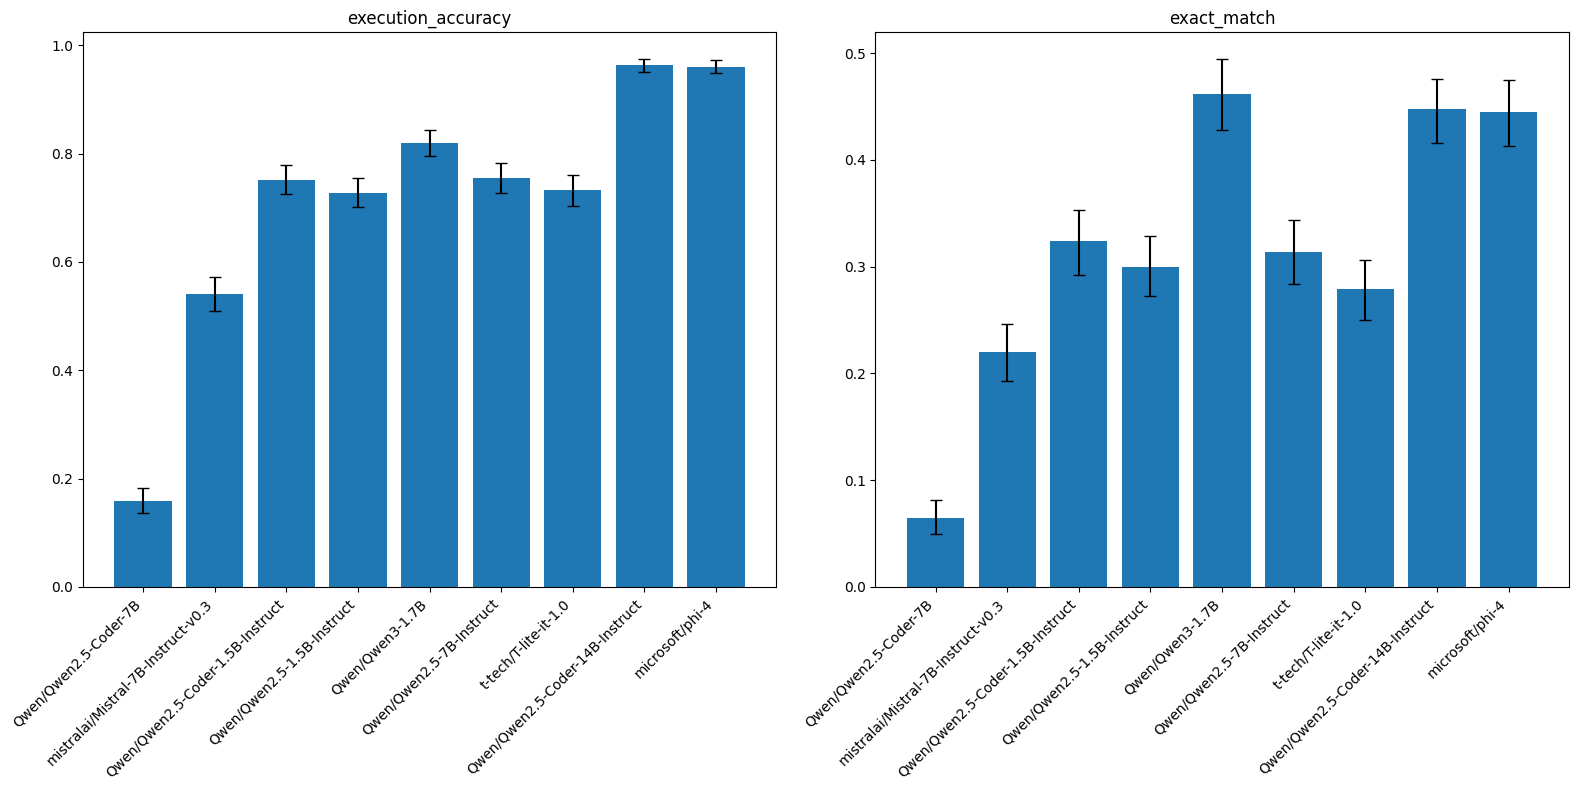

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharey=False)
axes = axes.ravel()

slice_df = plot_df[(plot_df['metric'] == 'execution_accuracy') | (plot_df['metric'] == 'exact_match')]

for i, metric in enumerate(slice_df['metric'].unique()):
    ax = axes[i]
    sub = slice_df[slice_df['metric'] == metric]

    x = range(len(sub))
    
    ax.bar(
        x,
        sub['point'],
        yerr=[sub['point'] - sub['lower'], sub['upper'] - sub['point']],
        capsize=4
    )
    ax.set_title(metric)

    ax.set_xticks(x)
    ax.set_xticklabels(sub['model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

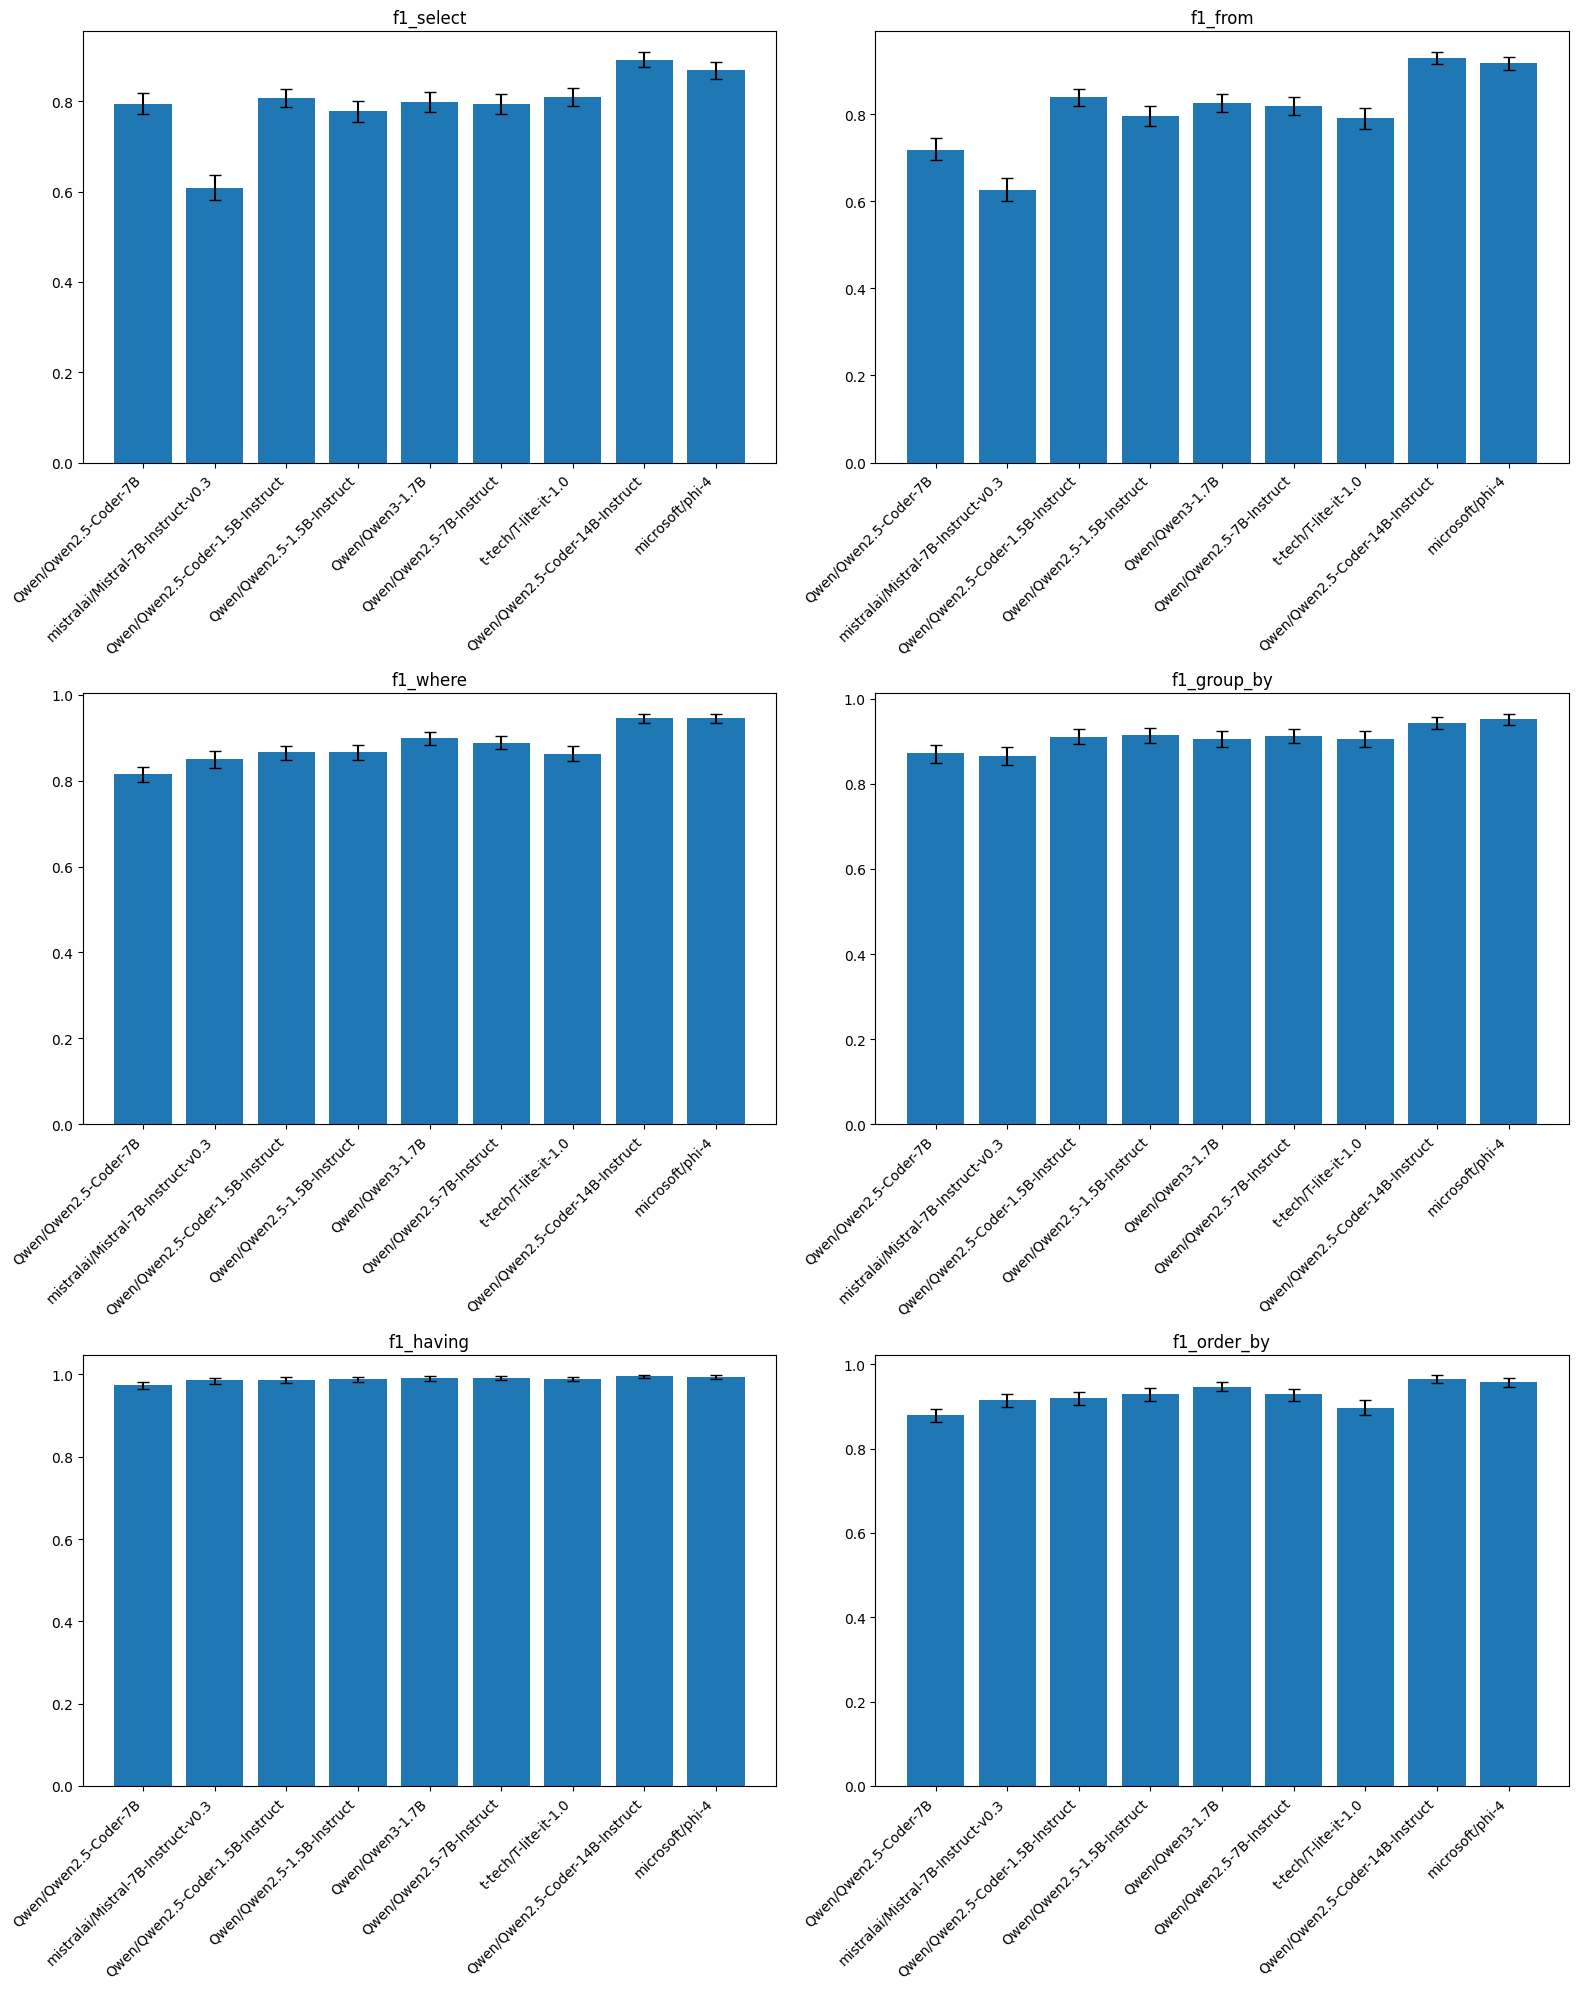

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,20), sharey=False)
axes = axes.ravel()

slice_df = plot_df[(plot_df['metric'] != 'execution_accuracy') & (plot_df['metric'] != 'exact_match')]

for i, metric in enumerate(slice_df['metric'].unique()):
    ax = axes[i]
    sub = slice_df[slice_df['metric'] == metric]

    x = range(len(sub))
    
    ax.bar(
        x,
        sub['point'],
        yerr=[sub['point'] - sub['lower'], sub['upper'] - sub['point']],
        capsize=4
    )
    ax.set_title(metric)

    ax.set_xticks(x)
    ax.set_xticklabels(sub['model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()